In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Basic Setup

Create anaconda environment
<br>
```bash
conda create -n ml python=3.7.5 jupyter
```
Install fastai library
<br>
```bash
conda install -c pytorch -c fastai fastai
```

In [ ]:
import matplotlib.pyplot as plt

## Prepare the dataset

In [ ]:
from sklearn.datasets import fetch_openml

In [ ]:
X, y_str = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
img1 = X[1].reshape(28, 28)
plt.imshow(img1)

In [ ]:
y_int = y_str.astype(int)

def encode_idx(idx):
    cd = np.zeros(10)
    cd[idx] = 1
    
    return cd
    
y_v = np.array([encode_idx(i) for i in y_int])

In [ ]:
y_v.shape

In [ ]:
X_norm = X / 255.

In [ ]:
X_train, X_test = X_norm[:60000], X_norm[60000:]
y_train, y_test = y_v[:60000], y_v[60000:]

In [ ]:
img_norm = X_train[0].reshape(28, 28)
plt.imshow(img_norm)

In [ ]:
training_dt = [(x.reshape(784, 1), y.reshape(10, 1)) for (x, y) in zip(X_train, y_train)]
test_dt = [(x.reshape(784, 1), y.reshape(10, 1)) for (x, y) in zip(X_test, y_test)]

## Save the dataset

In [ ]:
from pathlib import Path
import gzip
import pickle as pkl

In [ ]:
path = Path('data')
mnist = path / 'mnist'
mnist.mkdir(exist_ok=True)

In [ ]:
training_dt_path = mnist / 'training_dt.pickle'
test_dt_path = mnist / 'test_dt.pickle'

In [ ]:
def save_data(data_path, data_set):
    with data_path.open(mode='wb') as fl:
        pkl.dump(data_set, fl)

In [ ]:
def load_data(data_path):
    with data_path.open(mode='rb') as fl:
        data_set = pkl.load(fl)
    
    return data_set

In [ ]:
save_data(training_dt_path, training_dt)

In [ ]:
save_data(test_dt_path, test_dt)

In [ ]:
training_dt_ld = load_data(training_dt_path)

In [ ]:
test_dt_ld = load_data(test_dt_path)

## Create the Model

In [ ]:
import random
import pickle

In [ ]:
import numpy as np

In [ ]:
from collections import OrderedDict

Define sigmoid function

In [ ]:
def sigmoid(z:np.ndarray):
    return 1.0 / (1.0 + np.exp(-z))

Define derivative of sigmoid function

In [ ]:
def sigmoid_der(z):
    return sigmoid(z) * (1 - sigmoid(z))

Implement the linear layer of our neural network
<br>
$$
z = Wx + b
$$

In [ ]:
class Linear(object):
    
    def __init__(self, din:int, dout:int, bias:bool=True):
        super().__init__()
        self.din = din
        self.dout = dout
        self.bias = bias
        self.W = np.random.randn(dout, din)
        self.b = np.random.randn(dout, 1)
        self.a = None
        self.z = None
        self.der_W = np.zeros(self.W.shape)
        self.der_b = np.zeros(self.b.shape)
        
    def forward(self, a:np.ndarray):
        self.a = a
        self.z = self.W @ a + self.b
        
        return self.z
    
    def backward(self, delta_n:np.ndarray, z_p:np.ndarray):
        sd = sigmoid_der(z_p)
        delta = (self.W.T @ delta_n) * sd
        self.der_W += delta_n @ self.a.T
        self.der_b += delta_n
        
        return delta
    
    def zero_grad(self):
        self.der_W = np.zeros(self.W.shape)
        self.der_b = np.zeros(self.b.shape)
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def __str__(self):
        return f'Linear({self.din}, {self.dout})'
    
    def __repr__(self):
        return self.__str__()

Now we can implement the network

In [ ]:
class NNetwork(object):
    
    def __init__(self):
        super().__init__()
        self.layers = list()
        self.acts = list()
        self.layer_dict = OrderedDict()
        
    def forward(self, *args, **kwargs):
        pass
    
    def backward(self, x, y, out, **kwargs):
        z_p = None,
        delta = (out - y) * sigmoid_der(self.layers[-1].z)
        for i in range(1, len(self.layers) + 1):
            layer = self.layers[-i]
            z_p = self.layers[-i - 1].z if i < len(self.layers) else x
            delta = layer.backward(delta, z_p)
            
    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()
            
    def save(self, filename:str):
        weight_dict = dict()
        for k, v in self.layer_dict.items():
            weight_dict[k] = [v.W, v.b]
        with open(filename, 'wb') as handle:
            pickle.dump(weight_dict, handle)
            
    def load(self, filename:str):
        with open(filename, 'rb') as handle:
            weight_dict = pickle.load(handle)
        for k, (W, b) in weight_dict.items():
            if k in self.layer_dict:
                self.layer_dict[k].W = W
                self.layer_dict[k].b = b
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def __setattr__(self, name, value):
        super().__setattr__(name, value)
        if not hasattr(self, 'layers'):
            self.layers = []
        if not hasattr(self, 'layer_dict'):
            self.layer_dict = OrderedDict()
        if isinstance(value, Linear):
            self.layers.append(value)
            self.layer_dict[name] = value

#### Simple feed forward model

In [ ]:
class NNModel(NNetwork):
    
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(28*28, 100)
        self.fc2 = Linear(100, 50)
        self.fc3 = Linear(50, 10)
        
    def forward(self, x:np.ndarray):
        z1 = self.fc1(x)
        a1 = sigmoid(z1)
        z2 = self.fc2(a1)
        a2 = sigmoid(z2)
        z3 = self.fc3(a2)
        out = sigmoid(z3)
        
        return out
        

In [ ]:
model = NNModel()

In [ ]:
model.layers

In [ ]:
model.layer_dict

Initialize random label and test backward (backpropagation) and zero_grad methods

In [ ]:
x = np.random.rand(28*28, 1)
pred = model(x)
out = np.argmax(pred)

In [ ]:
y = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]).reshape(10, 1)
y.shape

In [ ]:
model.backward(x, y, pred)

In [ ]:
for ll in model.layers:
    print(ll.der_W.shape, ll.der_b.shape)

## SGD with momentum

Momentum implementation

In [ ]:
beta=0.9

Now we need to implement the loss function and gradient descent algorithm

In [ ]:
class SGD(object):
    
    def __init__(self, lr, momentum=None):
        self.lr = lr
        self.beta= momentum
        self.v_w = dict()
        self.v_b = dict()
        
    def optimize(self, model, batch):
        for x, y in batch:
            y_hat = model(x)
            model.backward(x, y, y_hat)
        glob_w = 0.0
        glob_b = 0.0
        for layer in model.layers:
            max_w = np.max(np.absolute(layer.der_W))
            max_b = np.max(np.absolute(layer.der_b))
            glob_w = max(max_w, glob_w)
            glob_b = max(max_b, glob_b)
            if self.beta:
                self.v_w.setdefault(layer, np.zeros(layer.der_W.shape))
                self.v_b.setdefault(layer, np.zeros(layer.der_b.shape))
                self.v_w[layer] = self.beta * self.v_w[layer] + (1 - beta) * layer.der_W
                self.v_b[layer] = self.beta * self.v_b[layer] + (1 - beta) * layer.der_b
                layer.W = layer.W - self.lr * (self.v_w[layer])
                layer.b = layer.b - self.lr * (self.v_b[layer])
            else:
                layer.W = layer.W - self.lr * (layer.der_W / len(batch))
                layer.b = layer.b - self.lr * (layer.der_b / len(batch))
        model.zero_grad()
        
        return glob_w, glob_b

The stochastic gradient descent will calculate mean of gradients in batch then makes step for gradient descent with learning rate and cleans accumulated gradient s for next batch

In [ ]:
optimizer = SGD(0.4, momentum=0.9)

In [ ]:
model = NNModel()

After each epoch we'll run validation

In [ ]:
def validate(test_data):
    y_hats = [(np.argmax(model(x)), np.argmax(y)) for (x, y) in test_data]
    valid_res = sum(int(pred == y) for (pred, y) in y_hats)
    
    return valid_res


Here we call model (with updated weights and biases) and compare it's output with labels and count correct predictions 

In [ ]:
def train(model, optimizer, training_data, test_data, epochs:int=12, batch_size:int=16, verbose:bool=False):
        if test_data: n_test = len(test_data)
        n = len(training_data)
        glob_w, glob_b = 0.0, 0.0
        for j in range(epochs):
            random.shuffle(training_data)
            batches = [training_data[k:k + batch_size] for k in range(0, n, batch_size)]
            for batch in batches:
                max_w, max_b = optimizer.optimize(model, batch)
                glob_w, glob_b = max(max_w, glob_w), max(max_b, glob_b)
            if verbose:
                print(f'max_w = {glob_w}, max_b = {glob_b}')
            if test_data:
                valid_res = validate(test_data)
                print(f'Epoch {j}: {valid_res} / {n_test}, accuracy = {valid_res / n_test}')
            else:
                print(f'Epoch {j} complete')

The training methods will iterate over the epochs, shuffle before each epoch data, group them in batches, run gradient descent per batch and validate model

Let's train the model

In [ ]:
train(model, optimizer, training_dt, test_dt, epochs=12, batch_size=32)

## Serialize the Trained Weights

In [ ]:
from pathlib import Path

In [ ]:
path = Path('data') / 'weights.pkl'

In [ ]:
model.save(str(path))

In [ ]:
model_dsk = NNModel()

In [ ]:
W_1 = model_dsk.layers[0].W.copy()

In [ ]:
model_dsk.load(path)

In [ ]:
W_2 = model_dsk.layers[0].W.copy()

In [ ]:
np.all(W_1 == W_2)

## PyTorch and FastAI libraries

An open source machine learning framework that accelerates the path from research prototyping to production deployment. 
[PyTorch](https://pytorch.org/)

Install only PyTorch library:

```bash
conda install pytorch torchvision -c pytorch
```

Install only PyTorch library:

```bash
pip install torch torchvision
```

The fastai deep learning library is more like scikit-learn on top of PyTorch
[FastAI](https://www.fast.ai/)
[FastAI GitHub](https://github.com/fastai/fastai)

Install with fastai library:
```bash
conda install -c pytorch -c fastai fastai
```

Install with fastai library:
```bash
pip install fastai
```

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
import torch.nn.functional as F

In [ ]:
import numpy as np
from pathlib import Path

In [ ]:
import matplotlib.pyplot as plt

## Prepare dataset

In [ ]:
t = torch.Tensor(64, 28, 28)
print(t.size())
t_v = t.view(t.size(0), -1)
t_v.size()

```python
class FlattenTensor(object):
    
    def __init__(self):
        super().__init__()
        
    def flatten(self, x):
        return x.view(-1, 784)
        
    def __call__(self, *args, **kwargs):
        return flatten(*args, **kwargs)
```

In [ ]:
?? transforms.ToTensor

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

## Download the dataset

In [ ]:
path = Path('data')
mnist_tensors = path / 'mnist_tensors'

In [ ]:
trainset = datasets.MNIST(str(mnist_tensors), download=True, train=True, transform=transform)
valset = datasets.MNIST(str(mnist_tensors), download=True, train=False, transform=transform)

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=0)

We initialized dataset with transforms and generated dataloader which will shuffle data and load it per batches:
<br>

Parameters for datasets.MNIST:
- path to download
- download: if data should be downloaded
- train: is it training set or validation set
- transform: transformations (preprocessing)

<br>
Parameters for torch.utils.data.DataLoader:
- dataset which should be loaded iteratively
- batch_size: mini-batch size
- shuffle: shuffle data per batch
- num_workers: number of threads for data loading


Parameters for datasets.MNIST:
- path to download
- download: if data should be downloaded
- train: is it training set or validation set
- transform: transformations (preprocessing)

<br>
Parameters for torch.utils.data.DataLoader:
- dataset which should be loaded iteratively
- batch_size: mini-batch size
- shuffle: shuffle data per batch
- num_workers: number of threads for data loading


#### Look into the data

In [ ]:
data_iter = iter(trainloader)
images, labels = data_iter.next()

print(images.shape)
print(labels.shape)

In [ ]:
plt.imshow(images[6].numpy().squeeze(), cmap='gray_r');

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Build the neural network

In [ ]:
class NNModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 50)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(50, 10)
        self.ac3 = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        z1 = self.fc1(x)
        a1 = self.ac1(z1)
        z2 = self.fc2(a1)
        a2 = self.ac2(z2)
        z3 = self.fc3(a2)
        out = self.ac3(z3)
        
        return out

In [ ]:
# ?? nn.Module

In [ ]:
# ?? nn.Linear

#### LogSoftmax:

Instead of using the sigmoid let's define more probabilistic function:
$$
softmax(x) = \frac{e^{x_k}}{\sum_{i}e^{x_i}}
$$
and 
$$
logsoftmax(x) = log(\frac{e^{x_k}}{\sum_{i}e^{x_i}})
$$

In [ ]:
softmax = F.softmax

In [ ]:
model = NNModel()

In [ ]:
model

## Define loss and optimizer

In [ ]:
criterion = nn.NLLLoss()

In [ ]:
# ?? nn.NLLLoss

In [ ]:
#list(model.parameters())

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Prepare training iteration

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
model = model.to(device)

In [ ]:
from time import time

In [ ]:
def validate(model, valloader):
    model.eval()
    correct, total = 0.0, 0.0
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        imgs = images.view(-1, 784)
        with torch.no_grad():
            logits = model(imgs)
        _, preds = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    print("\nValidation Accuracy =", (correct / total))

In [ ]:
def train(model, trainloader, valloader, criterion, optimizer, valid_funct=validate, epochs=16, val_step=10):
    for e in range(epochs):
        running_loss = 0
        start_time = time()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            model.train()
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Training pass
            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            #This is where the model learns by backpropagating
            loss.backward()

            #And optimizes its weights here
            optimizer.step()

            running_loss += loss.item()
        else:
            print(f'Epoch {e + 1} - Training loss: {running_loss/len(trainloader)}')
            model.eval()
            valid_funct(model, valloader)
    print(f'\nTraining Time (in minutes) = {(time() - start_time) / 60}')

In [ ]:
train(model, trainloader, valloader, criterion, optimizer)

## Train other model

In [ ]:
class NNEmbedding(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 50)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(50, 10)
    
    def forward(self, x):
        z1 = self.fc1(x)
        a1 = self.ac1(z1)
        z2 = self.fc2(a1)
        a2 = self.ac2(z2)
        out = self.fc3(a2)
        
        return out

In [ ]:
embedd = NNEmbedding()

In [ ]:
softmax = nn.Softmax(dim=1)

In [ ]:
import torch.nn.functional as F

In [ ]:
def validate_softmax(model, valloader):
    model.eval()
    correct_count, all_count = 0.0, 0.0
    total = 0.0
    correct = 0.0
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        imgs = images.view(-1, 784)
        with torch.no_grad():
            logits = model(imgs)
        _, preds = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    print("\nModel Accuracy =", (correct / total))

## Define loss and optimizer

In [ ]:
cross_entr = nn.CrossEntropyLoss() 

In [ ]:
rms_prop = optim.RMSprop(model.parameters(), lr=0.01)

In [ ]:
train(embedd, trainloader, valloader, cross_entr, rms_prop, valid_funct=validate_softmax)

## Train model with FastAI library

In [55]:
from fastai.basics import *

In [56]:
from pathlib import Path
import gzip
import pickle

## Prepare data

In [57]:
path = Path('data')

In [58]:
mnist_fastai = path / 'mnist_fastai'

In [59]:
! wget -P {mnist_fastai} http://deeplearning.net/data/mnist/mnist.pkl.gz

--2020-02-20 20:51:23--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘data/mnist_fastai/mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M   827KB/s    in 21s     

2020-02-20 20:51:46 (737 KB/s) - ‘data/mnist_fastai/mnist.pkl.gz’ saved [16168813/16168813]



In [61]:
with gzip.open(mnist_fastai /'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

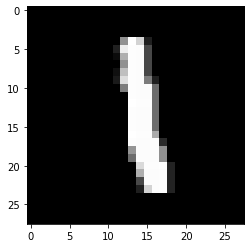

In [63]:
plt.imshow(x_train[6].reshape((28,28)), cmap='gray')
x_train.shape

In [65]:
#x_train, y_train, x_valid, y_valid = map(torch.tensor, 
#                                      (x_train, y_train, x_valid, y_valid))
x_train, y_train, x_valid, y_valid = [torch.tensor(d) for d in (x_train, y_train, x_valid, y_valid)]
n, c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [68]:
x_valid.shape

torch.Size([10000, 784])

Define datasets:

In [69]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs, num_workers=0)

In [70]:
type(data.train_dl)

fastai.basic_data.DeviceDataLoader

In [71]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

## Initialize model

In [77]:
net = nn.Sequential(nn.Linear(28 * 28, 128),
                    nn.ReLU(),
                    nn.Linear(128, 64, bias=True),
                    nn.ReLU(),
                    nn.Linear(64, 10, bias=True))

In [85]:
net = nn.Sequential(OrderedDict([
                        ('fc1', nn.Linear(28 * 28, 128)),
                        ('ac1', nn.ReLU()),
                        ('fc2', nn.Linear(128, 64, bias=True)),
                        ('ac2', nn.ReLU()),
                        ('fc3', nn.Linear(64, 10, bias=True))]))

In [74]:
#?? nn.Linear

In [83]:
# ?? nn.Sequential

In [86]:
net

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Initialize learner

In [90]:
loss_func = nn.CrossEntropyLoss()

In [91]:
learn = Learner(data, net, loss_func=loss_func, metrics=accuracy)

In [92]:
# ?? Learner

#### Find learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


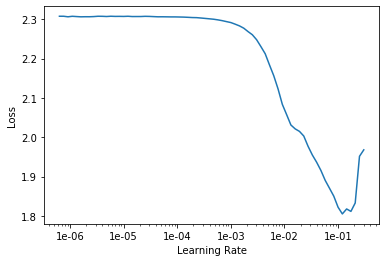

In [93]:
learn.lr_find()
learn.recorder.plot()

#### Train the model

In [97]:
learn.fit_one_cycle(4, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.193418,0.217161,0.948800,00:02
1,0.170604,0.168824,0.960700,00:02
2,0.108228,0.128612,0.967800,00:02
3,0.045395,0.098553,0.976600,00:02


#### Make some analysis

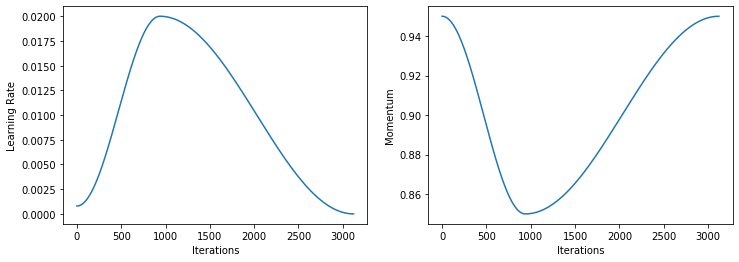

In [95]:
learn.recorder.plot_lr(show_moms=True)

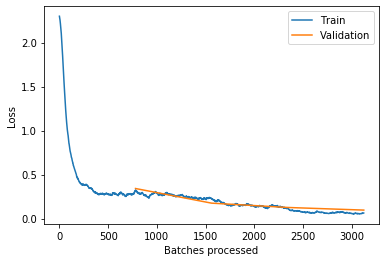

In [96]:
learn.recorder.plot_losses()

## Questions